## Importing Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from deepsnap.hetero_graph import HeteroGraph
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from torch_sparse import SparseTensor, matmul
import warnings
import copy
import torch
import deepsnap
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as pyg_nn
import random
from sklearn.metrics import roc_auc_score
from deepsnap.hetero_gnn import forward_op
from deepsnap.hetero_graph import HeteroGraph
from torch_sparse import SparseTensor, matmul
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec
from data_utils import haversine
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

## Data Loading and Preprocessing

In [11]:
class GraphBuilder:
    """Build and cache heterogeneous graphs for each timestamp"""
    def __init__(self, filepath):
        self.filepath = filepath
        self.spatial_scaler = StandardScaler()
        self.time_scaler = StandardScaler()
        self.df = None
        self.spatial_features = None
        self.spatial_nodes = None
        self.radius_to_idx = None
        self.spatial_edges = None
        self.spatial_edge_weights = None
        self.all_months = None
        
    def load_and_preprocess(self):
        """Load data and create static components"""
        print("Loading data...")
        self.df = pd.read_excel(self.filepath)
        self.df['event_month'] = (self.df['event_time'] * 12).astype(int)
        self.df = self.df.sort_values('event_month').reset_index(drop=True)
        
        # Get all unique months
        self.all_months = sorted(self.df['event_month'].unique())
        
        # Create spatial nodes (static)
        self.spatial_nodes = self.df.groupby('fault_radius').agg({
            'magnitude': 'mean',
            'latitude': 'mean',
            'longitude': 'mean',
            'depth': 'mean'
        }).reset_index()
        
        self.radius_to_idx = {radius: idx for idx, radius in enumerate(self.spatial_nodes['fault_radius'])}
        
        features = self.spatial_nodes[['magnitude', 'latitude', 'longitude', 'depth']].values
        self.spatial_features = torch.FloatTensor(self.spatial_scaler.fit_transform(features))
        
        # Create spatial-spatial edges with weights
        self.spatial_edges, self.spatial_edge_weights = self._create_spatial_edges()
        
        print(f"Loaded {len(self.spatial_nodes)} spatial nodes, {self.spatial_edges.shape[1]} spatial edges, {len(self.all_months)} time steps")
        
    def _create_spatial_edges(self):
        """Create edges between all spatial nodes with distance as weights"""
        n = len(self.spatial_nodes)
        edge_index = [[], []]
        edge_weights = []
        
        for i in range(n):
            for j in range(i+1, n):
                lat1, lon1 = self.spatial_nodes.iloc[i]['latitude'], self.spatial_nodes.iloc[i]['longitude']
                lat2, lon2 = self.spatial_nodes.iloc[j]['latitude'], self.spatial_nodes.iloc[j]['longitude']
                
                dist = haversine(lon1, lat1, lon2, lat2)
                
                # Add edges in both directions
                edge_index[0].extend([i, j])
                edge_index[1].extend([j, i])
                # Add weight for both directions
                edge_weights.extend([dist, dist])
        edge_weights = torch.FloatTensor(edge_weights)
        max_dist = torch.max(edge_weights)
        edge_weights = 1 - (edge_weights / max_dist)  # Normalize to [0, 1] and invert (closer -> higher weight)
        
        return torch.LongTensor(edge_index), edge_weights
    
    def create_time_features(self, months):
        """Create time node features for given months"""
        time_features = []
        for month in months:
            sin_month = np.sin(2 * np.pi * (month / 12))
            cos_month = np.cos(2 * np.pi * (month / 12))
            time_features.append([sin_month, cos_month, month / 12])
        
        time_features = np.array(time_features)
        return torch.FloatTensor(self.time_scaler.fit_transform(time_features))
    
    def build_graph_up_to_month(self, cutoff_month, target_month):
        """Build heterogeneous graph with all data up to cutoff_month"""
        # Filter data up to cutoff
        past_df = self.df[self.df['event_month'] <= cutoff_month]
        past_months = [i for i in range(target_month + 1)]
        
        
        # Create time features
        time_features = self.create_time_features(past_months)
        
        # Create spatial-time edges with earthquake magnitude as edge weight
        st_edge_index = [[], []]
        st_edge_weights = []  
        for _, row in past_df.iterrows():
            if row['fault_radius'] in self.radius_to_idx:
                spatial_idx = self.radius_to_idx[row['fault_radius']]
                time_idx = row['event_month']
                st_edge_index[1].append(spatial_idx)
                st_edge_index[0].append(time_idx)
                st_edge_weights.append(row['magnitude'])
        
        # Normalize spatial-time edge weights
        st_edge_weights = torch.FloatTensor(st_edge_weights)
        st_edge_weights = (st_edge_weights - st_edge_weights.min()) / (st_edge_weights.max() - st_edge_weights.min())
        
        # Create time edges with weight 1
        time_index = [[], []]
        time_weights = []  # NEW: Store weights for time edges
        for i in range(len(past_months) - 1):  # -1 because we connect to i+1
            time_index[0].append(i)
            time_index[1].append(i + 1)
            time_weights.append(1.0)  # NEW: Weight of 1 for all time edges
        
        st_edges = torch.LongTensor(st_edge_index)
        st_weights = st_edge_weights
        time_index = torch.LongTensor(time_index)
        time_weights = torch.FloatTensor(time_weights) 

        # Create HeteroData with edge weights
        node_feature = {
            'spatial': self.spatial_features,
            'time': time_features
        }
        edge_index = {
            ('spatial', 'nearby', 'spatial'): self.spatial_edges,
            ('time', 'event', 'spatial'): st_edges,
            ('time', 'past', 'time'): time_index
        }
        edge_weight = {
            ('spatial', 'nearby', 'spatial'): self.spatial_edge_weights,
            ('time', 'event', 'spatial'): st_weights,  
            ('time', 'past', 'time'): time_weights  
        }
        
        data = HeteroGraph(
            node_feature=node_feature,
            edge_index=edge_index,
            edge_weight=edge_weight
        )
        
        return data
    
    def get_target_edges_for_month(self, target_month):
        """Get positive and negative target edges for a specific month"""
        target_df = self.df[self.df['event_month'] == target_month]
        
        # Positive edges
        pos_edges = [[], []]
        for _, row in target_df.iterrows():
            if row['fault_radius'] in self.radius_to_idx:
                spatial_idx = self.radius_to_idx[row['fault_radius']]
                time_idx = target_month
                pos_edges[1].append(spatial_idx)
                pos_edges[0].append(time_idx)
        
        pos_edges = torch.LongTensor(pos_edges) if pos_edges[0] else torch.LongTensor([[], []])
        
        # Negative edges
        if pos_edges.shape[1] > 0:
            neg_edges = self._create_negative_samples(
                pos_edges, len(self.spatial_nodes), target_month
            )
        else:
            neg_edges = torch.LongTensor([[], []])
        
        return pos_edges, neg_edges
    
    def _create_negative_samples(self, pos_edges, num_spatial, target_time_idx):
        """Create negative samples"""
        pos_set = set(zip(pos_edges[0].tolist(), pos_edges[1].tolist()))
        neg_edges = [[], []]
        
        num_neg_needed = pos_edges.shape[1]
        attempts = 0
        max_attempts = num_neg_needed * 10
        
        while len(neg_edges[0]) < num_neg_needed and attempts < max_attempts:
            spatial_idx = np.random.randint(0, num_spatial)
            if (target_time_idx, spatial_idx) not in pos_set and spatial_idx not in neg_edges[1]:
                neg_edges[1].append(spatial_idx)
                neg_edges[0].append(target_time_idx)
            attempts += 1
        
        return torch.LongTensor(neg_edges)
    
    def prepare_training_data(self, train_months, index):
        """Pre-build all training, val and test graphs"""
        print("\nPre-building training graphs...")
        training_samples = []
        
        for i in range(index, len(train_months)):
            past_cutoff = train_months[i-1]
            target_month = train_months[i]
            
            # Build graph up to past_cutoff
            data = self.build_graph_up_to_month(past_cutoff, target_month)
            
            # Get target edges
            pos_edges, neg_edges = self.get_target_edges_for_month(target_month)
            
            if pos_edges.shape[1] > 0 and neg_edges.shape[1] > 0:
                training_samples.append((data, pos_edges, neg_edges))
        
        print(f"Prepared {len(training_samples)} samples")
        return training_samples
    
    def convert_edges_to_sparse_tensors(self, training_samples):
        """Convert edge indices to sparse tensors with edge weights"""
        updated_data = []
        for i in range(len(training_samples)):
            hetero_graph = training_samples[i][0]
            for key in hetero_graph.edge_index:
                edge_index = hetero_graph.edge_index[key]
                
                edge_weight = hetero_graph.edge_weight[key]
                # Create SparseTensor
                adj = SparseTensor(
                    row=edge_index[0], 
                    col=edge_index[1], 
                    value=edge_weight,  
                    sparse_sizes=(hetero_graph.num_nodes(key[0]), hetero_graph.num_nodes(key[2]))
                )
                
                hetero_graph.edge_index[key] = adj.t()  # Transpose for neighbor aggregation
            
            updated_data.append((hetero_graph, training_samples[i][1], training_samples[i][2]))
        return updated_data

In [14]:
filepath = "E:/Stanford University/Autumn25/CS224W/main_project/project_code/data/real_data.xlsx"
builder = GraphBuilder(filepath)
builder.load_and_preprocess()

# Split months
train_cutoff_month = int(26 * 12)
val_cutoff_month = int(29 * 12)

train_months = [m for m in builder.all_months if m <= train_cutoff_month]
val_months = [m for m in builder.all_months if train_cutoff_month < m <= val_cutoff_month]
test_months = [m for m in builder.all_months if m > val_cutoff_month]

print(f"\nSplit: Train={len(train_months)} months, Val={len(val_months)} months, Test={len(test_months)} months")

# Pre-build all training samples
training_samples = builder.prepare_training_data(train_months, 1)
val_samples = builder.prepare_training_data(train_months + val_months, len(train_months))
test_samples = builder.prepare_training_data(train_months + val_months + test_months, len(train_months) + len(val_months))

training_samples = builder.convert_edges_to_sparse_tensors(training_samples)
val_samples = builder.convert_edges_to_sparse_tensors(val_samples)
test_samples = builder.convert_edges_to_sparse_tensors(test_samples)

Loading data...
Loaded 239 spatial nodes, 56882 spatial edges, 366 time steps

Split: Train=310 months, Val=35 months, Test=21 months

Pre-building training graphs...
Prepared 309 samples

Pre-building training graphs...
Prepared 35 samples

Pre-building training graphs...
Prepared 21 samples


## HeteroGNN Model Class from Colab 5

In [16]:
from Cython import returns


class HeteroGNNConv(pyg_nn.MessagePassing):
    def __init__(self, in_channels_src, in_channels_dst, out_channels):
        super(HeteroGNNConv, self).__init__(aggr="mean")

        self.in_channels_src = in_channels_src
        self.in_channels_dst = in_channels_dst
        self.out_channels = out_channels

        self.lin_dst = None
        self.lin_src = None
        self.lin_update = None

        self.lin_dst = nn.Linear(in_channels_dst, out_channels)
        self.lin_src = nn.Linear(in_channels_src, out_channels)
        self.lin_update = nn.Linear(2 * out_channels, out_channels)


    def forward(
        self,
        node_feature_src,
        node_feature_dst,
        edge_index,
        size=None
    ):
        return self.propagate(edge_index, node_feature_src=node_feature_src, node_feature_dst=node_feature_dst)


    def message_and_aggregate(self, edge_index, node_feature_src):

        out = None
        out = matmul(edge_index, node_feature_src, reduce = self.aggr)
        out = self.lin_src(out)

        return out

    def update(self, aggr_out, node_feature_dst):

        node_feature_dst = self.lin_dst(node_feature_dst)
        aggr_out = torch.concat((node_feature_dst, aggr_out), dim = 1)
        aggr_out = self.lin_update(aggr_out)

        return aggr_out


class HeteroGNNWrapperConv(deepsnap.hetero_gnn.HeteroConv):
    def __init__(self, convs, args, aggr="mean"):
        super(HeteroGNNWrapperConv, self).__init__(convs, None)
        self.aggr = aggr

        # Map the index and message type
        self.mapping = {}

        # A numpy array that stores the final attention probability
        self.alpha = None

        self.attn_proj = None

        if self.aggr == "attn":

            self.attn_proj = nn.Sequential(
                nn.Linear(args['hidden_size'], args['attn_size']),
                nn.Tanh(),
                nn.Linear(args['attn_size'], 1, bias = False)
            )

    def reset_parameters(self):
        super(HeteroConvWrapper, self).reset_parameters()
        if self.aggr == "attn":
            for layer in self.attn_proj.children():
                layer.reset_parameters()

    def forward(self, node_features, edge_indices):
        message_type_emb = {}
        for message_key, message_type in edge_indices.items():
            src_type, edge_type, dst_type = message_key
            node_feature_src = node_features[src_type]
            node_feature_dst = node_features[dst_type]
            edge_index = edge_indices[message_key]
            message_type_emb[message_key] = (
                self.convs[message_key](
                    node_feature_src,
                    node_feature_dst,
                    edge_index,
                )
            )
        node_emb = {dst: [] for _, _, dst in message_type_emb.keys()}
        mapping = {}
        for (src, edge_type, dst), item in message_type_emb.items():
            mapping[len(node_emb[dst])] = (src, edge_type, dst)
            node_emb[dst].append(item)
        self.mapping = mapping
        for node_type, embs in node_emb.items():
            if len(embs) == 1:
                node_emb[node_type] = embs[0]
            else:
                node_emb[node_type] = self.aggregate(embs)
        return node_emb

    def aggregate(self, xs):

        if self.aggr == "mean":
            return torch.mean(torch.stack(xs, dim = 0), dim = 0)

        elif self.aggr == "attn":
            N = xs[0].shape[0] # Number of nodes for that node type
            M = len(xs) # Number of message types for that node type

            x = torch.cat(xs, dim=0).view(M, N, -1) # M * N * D
            z = self.attn_proj(x).view(M, N) # M * N * 1
            z = z.mean(1) # M * 1
            alpha = torch.softmax(z, dim=0) # M * 1

            # Store the attention result to self.alpha as np array
            self.alpha = alpha.view(-1).data.cpu().numpy()

            alpha = alpha.view(M, 1, 1)
            x = x * alpha
            return x.sum(dim=0)


def generate_convs(hetero_graph, conv, hidden_size, first_layer=False):
    """
    Returns a dictionary of `HeteroGNNConv`
    layers where the keys are message types. `hetero_graph` is deepsnap `HeteroGraph`
    object and the `conv` is the `HeteroGNNConv`.
    """
    convs = {}

    for message_type in hetero_graph.message_types:
        src_type, edge_type, dst_type = message_type
        if first_layer:
            in_channels_src = hetero_graph.num_node_features(src_type)
            in_channels_dst = hetero_graph.num_node_features(dst_type)
        else:
            in_channels_src = hidden_size
            in_channels_dst = hidden_size
        convs[message_type] = conv(in_channels_src, in_channels_dst, hidden_size)

    return convs


class HeteroGNN(torch.nn.Module):
    def __init__(self, hetero_graph, args, aggr="mean"):
        super(HeteroGNN, self).__init__()

        self.aggr = aggr
        self.hidden_size = args['hidden_size']

        self.convs1 = None
        self.convs2 = None

        self.bns1 = nn.ModuleDict()
        self.bns2 = nn.ModuleDict()
        self.bns3 = nn.ModuleDict()
        self.bns4 = nn.ModuleDict()
        self.bns5 = nn.ModuleDict()
        self.relus1 = nn.ModuleDict()
        self.relus2 = nn.ModuleDict()
        self.relus3 = nn.ModuleDict()
        self.relus4 = nn.ModuleDict()
        self.relus5 = nn.ModuleDict()
        
        self.w1 = torch.nn.Linear(self.hidden_size, self.hidden_size)
        self.w2 = torch.nn.Linear(self.hidden_size, self.hidden_size)

        convs1_dict = generate_convs(hetero_graph, HeteroGNNConv, self.hidden_size, True)
        self.convs1 = HeteroGNNWrapperConv(convs1_dict, args, self.aggr)
        convs2_dict = generate_convs(hetero_graph, HeteroGNNConv, self.hidden_size, False)
        self.convs2 = HeteroGNNWrapperConv(convs2_dict, args, self.aggr)
        convs3_dict = generate_convs(hetero_graph, HeteroGNNConv, self.hidden_size, False)
        self.convs3 = HeteroGNNWrapperConv(convs3_dict, args, self.aggr)
        convs4_dict = generate_convs(hetero_graph, HeteroGNNConv, self.hidden_size, False)
        self.convs4 = HeteroGNNWrapperConv(convs4_dict, args, self.aggr)
        convs5_dict = generate_convs(hetero_graph, HeteroGNNConv, self.hidden_size, False)
        self.convs5 = HeteroGNNWrapperConv(convs5_dict, args, self.aggr)
        for node_type in hetero_graph.node_types:
            self.bns1[node_type] = nn.BatchNorm1d(self.hidden_size, eps = 1)
            self.bns2[node_type] = nn.BatchNorm1d(self.hidden_size, eps = 1)
            self.bns3[node_type] = nn.BatchNorm1d(self.hidden_size, eps = 1)
            self.bns4[node_type] = nn.BatchNorm1d(self.hidden_size, eps = 1)
            self.bns5[node_type] = nn.BatchNorm1d(self.hidden_size, eps = 1)
            self.relus1[node_type] = nn.LeakyReLU()
            self.relus2[node_type] = nn.LeakyReLU()
            self.relus3[node_type] = nn.LeakyReLU()
            self.relus4[node_type] = nn.LeakyReLU()
            self.relus5[node_type] = nn.LeakyReLU()

    def forward(self, node_feature, edge_index, target_edges):
        x = node_feature
        
        # Store initial features for skip connections
        x_input = {key: val.clone() for key, val in x.items()}
        
        ############# Layer 1 #############
        x = self.convs1(edge_indices=edge_index, node_features=x)
        x = forward_op(x=x, module_dict=self.bns1)  # or layer norms
        
        x = forward_op(x=x, module_dict=self.relus1)
        
        # Node-type specific dropout
        for key in x.keys():
            x[key] = F.dropout(x[key], p=0.3, training=self.training)
        
        # Store for next skip connection
        x_layer1 = {key: val.clone() for key, val in x.items()}
        
        ############# Layer 2 #############
        x = self.convs2(edge_indices=edge_index, node_features=x)
        x = forward_op(x=x, module_dict=self.bns2)
        
        for key in x.keys():
            x[key] = x[key] + x_layer1[key]
        
        x = forward_op(x=x, module_dict=self.relus2)
        
        for key in x.keys():
            x[key] = F.dropout(x[key], p=0.3, training=self.training)
        
        # Store for next skip connection
        x_layer2 = {key: val.clone() for key, val in x.items()}
        
        ############# Layer 3 #############
        x = self.convs3(edge_indices=edge_index, node_features=x)
        x = forward_op(x=x, module_dict=self.bns3)
        
        for key in x.keys():
            x[key] = x[key] + x_layer2[key] + x_layer1[key]
        x = forward_op(x=x, module_dict=self.relus3)
        
        for key in x.keys():
            x[key] = F.dropout(x[key], p=0.3, training=self.training)

        # Store for next skip connection
        x_layer3 = {key: val.clone() for key, val in x.items()}
        
        ############# Layer 4 #############
        x = self.convs4(edge_indices=edge_index, node_features=x)
        x = forward_op(x=x, module_dict=self.bns4)
        
        for key in x.keys():
            x[key] = x[key] + x_layer3[key] + x_layer2[key] + x_layer1[key]
        x = forward_op(x=x, module_dict=self.relus4)
        
        for key in x.keys():
            x[key] = F.dropout(x[key], p=0.3, training=self.training)

        # Store for next skip connection
        x_layer4 = {key: val.clone() for key, val in x.items()}
        
        ############# Layer 5 #############
        x = self.convs5(edge_indices=edge_index, node_features=x)
        x = forward_op(x=x, module_dict=self.bns5)
        
        for key in x.keys():
            x[key] = x[key] + x_layer4[key] + x_layer3[key] + x_layer2[key] + x_layer1[key]
        x = forward_op(x=x, module_dict=self.relus5)
        
        for key in x.keys():
            x[key] = F.dropout(x[key], p=0.3, training=self.training) 
        
        ############# Edge Prediction #############
        time_indices = target_edges[0]
        spatial_indices = target_edges[1]
        
        x_time = x['time'][time_indices]
        x_spatial = x['spatial'][spatial_indices]
        
        return (F.cosine_similarity(self.w1(x_time), self.w2(x_spatial), dim=1).view(-1, 1))

## Function to train the Model and Metrics Calculation

In [19]:
def train_epoch(model, training_samples, optimizer, criterion, batch_size=16):
    """Train for one epoch using cached samples"""
    model.train()
    total_loss = 0
    batch_losses = []
    
    for i, (data, pos_edges, neg_edges) in enumerate(training_samples):
        neg_edges = builder._create_negative_samples(
            pos_edges, len(builder.spatial_nodes), pos_edges[0, 0].item()
        )
        x = torch.concatenate((pos_edges, neg_edges), axis=1)
        pred = model(data.node_feature, data.edge_index, x)
        y_true = torch.concatenate((torch.ones(pos_edges.shape[1]), 
                                     torch.zeros(neg_edges.shape[1]))).view(-1, 1)
        
        loss = criterion(pred, y_true)
        batch_losses.append(loss)
        
        # Accumulate gradients for batch_size samples
        if (i + 1) % batch_size == 0 or (i + 1) == len(training_samples):
            # Average the losses in the batch
            avg_loss = torch.stack(batch_losses).mean()
            
            optimizer.zero_grad()
            avg_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            total_loss += avg_loss.item() * len(batch_losses)
            batch_losses = []  # Reset for next batch
    
    return total_loss / len(training_samples)

@torch.no_grad()
def evaluate(model, all_samples, best_model = None, best_val = 0):
    """Evaluate model and return metrics and bext model"""
    accs = []
    for samples in all_samples:
        all_preds, all_labels = [], []
        for (data, pos_edges, neg_edges) in samples:
            model.eval()
            x = torch.concatenate((pos_edges, neg_edges), axis = 1)
            preds = model(data.node_feature, data.edge_index, x)
            labels = torch.concatenate((torch.ones(pos_edges.shape[1]), torch.zeros(neg_edges.shape[1]))).view(-1, 1)
            all_preds.append(preds)
            all_labels.append(labels)
        all_preds = torch.cat(all_preds)
        all_labels = torch.cat(all_labels)
        scores = compute_metrics(all_preds, all_labels)
        accs.append(scores)
    if accs[1]["f1"] > best_val:
        best_val = accs[1]["f1"]
        best_model = copy.deepcopy(model)
    return accs, best_model, best_val

def compute_metrics(all_preds, all_labels, threshold=0.5):
    """
    Compute different metrics from aggregated predictions and labels.
    """
    # Convert to numpy for sklearn metrics
    preds_proba = F.sigmoid(all_preds).detach().cpu().numpy()
    labels_np = all_labels.detach().cpu().numpy()
    
    # Binary predictions with chosen/optimized threshold
    pred_binary = (torch.sigmoid(all_preds) > threshold).float()
    
    # Basic accuracy
    accuracy = (pred_binary == all_labels).float().mean()
    
    # Confusion matrix components
    true_pos = ((pred_binary == 1) & (all_labels == 1)).sum().item()
    false_pos = ((pred_binary == 1) & (all_labels == 0)).sum().item()
    false_neg = ((pred_binary == 0) & (all_labels == 1)).sum().item()
    true_neg = ((pred_binary == 0) & (all_labels == 0)).sum().item()
    
    # Threshold-based metrics
    precision = true_pos / (true_pos + false_pos) if (true_pos + false_pos) > 0 else 0
    recall = true_pos / (true_pos + false_neg) if (true_pos + false_neg) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    
    # Probability-based metrics (require sklearn)
    try:
        roc_auc = roc_auc_score(labels_np, preds_proba)
    except:
        roc_auc = 0.0
    
    
    return {
        # Main metrics
        'accuracy': accuracy.item(),
        'roc_auc': roc_auc,
        'threshold': threshold,  # Include the threshold used
        
        # Classification metrics
        'precision': precision,
        'recall': recall,
        'f1': f1,
        
        # Confusion matrix
        'true_pos': true_pos,
        'false_pos': false_pos,
        'true_neg': true_neg,
        'false_neg': false_neg
    }


## Training Loop

In [20]:
best_model = None
best_val = 0

args = {
    'device': 'cpu',
    'hidden_size': 256,
    'epochs': 100,
    'weight_decay': 1e-5,
    'lr': 2e-3,
    'attn_size': 32,
}

model = HeteroGNN(training_samples[0][0], args, aggr="mean")
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])
criterion = nn.BCEWithLogitsLoss()

random.shuffle(training_samples)
random.shuffle(val_samples)
random.shuffle(test_samples)
scores_train = []
train_loss = []
scores_val = []
scores_test = []

for epoch in range(args['epochs']):
    
    loss = train_epoch(model, training_samples, optimizer, criterion)
    train_loss.append(loss)
    accs, best_model, best_val = evaluate(model, [training_samples, val_samples, test_samples], best_model, best_val)
    scores_train.append(accs[0])
    scores_val.append(accs[1])
    scores_test.append(accs[2])
    
    print(
        f"Epoch {epoch + 1}: loss {round(loss, 5)},"
        f"train {round(accs[0]['f1'] * 100, 2)}%,"
        f"valid {round(accs[1]['f1'] * 100, 2)}%,"
        f"test {round(accs[2]['f1'] * 100, 2)}%"
    )

best_accs, best_model, best_val = evaluate(best_model, [training_samples, val_samples, test_samples])
print(
    f"Best model: "
    f"train {round(best_accs[0]['f1'] * 100, 2)}%,"
    f"valid {round(best_accs[1]['f1'] * 100, 2)}%,"
    f"test {round(best_accs[2]['f1']* 100, 2)}%"
)

Epoch 1: loss 0.69122,train 41.64%,valid 24.86%,test 28.19%
Epoch 2: loss 0.68373,train 44.74%,valid 20.51%,test 24.46%
Epoch 3: loss 0.67619,train 42.5%,valid 11.37%,test 13.65%
Epoch 4: loss 0.67499,train 44.71%,valid 16.89%,test 16.99%
Epoch 5: loss 0.67029,train 46.88%,valid 16.67%,test 18.68%
Epoch 6: loss 0.66863,train 44.0%,valid 9.41%,test 12.77%
Epoch 7: loss 0.66691,train 48.35%,valid 17.16%,test 21.54%
Epoch 8: loss 0.66674,train 51.09%,valid 24.52%,test 21.89%
Epoch 9: loss 0.66684,train 49.99%,valid 24.18%,test 27.84%
Epoch 10: loss 0.66455,train 50.57%,valid 21.41%,test 22.66%
Epoch 11: loss 0.6677,train 50.15%,valid 24.12%,test 25.76%
Epoch 12: loss 0.66186,train 53.34%,valid 26.59%,test 27.46%
Epoch 13: loss 0.65908,train 50.54%,valid 21.56%,test 23.19%
Epoch 14: loss 0.66144,train 48.12%,valid 15.17%,test 16.67%
Epoch 15: loss 0.65589,train 54.06%,valid 33.08%,test 31.33%
Epoch 16: loss 0.66269,train 47.55%,valid 27.13%,test 22.05%
Epoch 17: loss 0.6572,train 51.69%,va

## Training Graphs

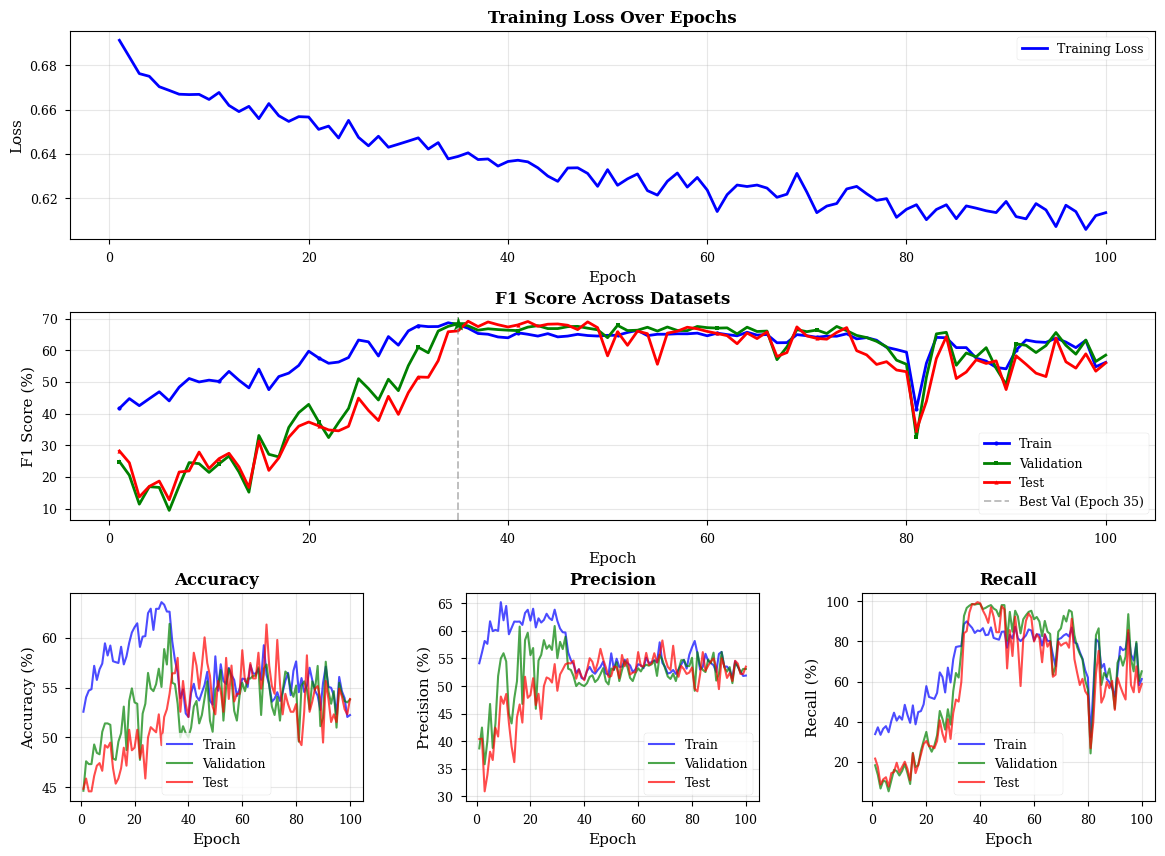

In [23]:
# Set style for good-quality plots  
plt.style.use('seaborn-v0_8-paper')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['legend.fontsize'] = 9
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9

# Create figure with multiple subplots
fig = plt.figure(figsize=(14, 10))
gs = GridSpec(3, 3, figure=fig, hspace=0.35, wspace=0.35)

epochs = range(1, len(train_loss) + 1)

# ============= Plot 1: Training Loss =============
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(epochs, train_loss, 'b-', linewidth=2, label='Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss Over Epochs', fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend()

# ============= Plot 2: F1 Score Comparison =============
ax2 = fig.add_subplot(gs[1, :])
train_f1 = [s['f1'] * 100 for s in scores_train]
val_f1 = [s['f1'] * 100 for s in scores_val]
test_f1 = [s['f1'] * 100 for s in scores_test]

ax2.plot(epochs, train_f1, 'b-', linewidth=2, label='Train', marker='o', markersize=3, markevery=10)
ax2.plot(epochs, val_f1, 'g-', linewidth=2, label='Validation', marker='s', markersize=3, markevery=10)
ax2.plot(epochs, test_f1, 'r-', linewidth=2, label='Test', marker='^', markersize=3, markevery=10)

# Mark best validation epoch
best_epoch = np.argmax(val_f1)
ax2.axvline(x=best_epoch+1, color='gray', linestyle='--', alpha=0.5, label=f'Best Val (Epoch {best_epoch+1})')
ax2.scatter([best_epoch+1], [val_f1[best_epoch]], color='g', s=100, zorder=5, marker='*')

ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1 Score (%)')
ax2.set_title('F1 Score Across Datasets', fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(loc='best')

# ============= Plot 3: Accuracy =============
ax3 = fig.add_subplot(gs[2, 0])
train_acc = [s['accuracy'] * 100 for s in scores_train]
val_acc = [s['accuracy'] * 100 for s in scores_val]
test_acc = [s['accuracy'] * 100 for s in scores_test]

ax3.plot(epochs, train_acc, 'b-', linewidth=1.5, label='Train', alpha=0.7)
ax3.plot(epochs, val_acc, 'g-', linewidth=1.5, label='Validation', alpha=0.7)
ax3.plot(epochs, test_acc, 'r-', linewidth=1.5, label='Test', alpha=0.7)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Accuracy (%)')
ax3.set_title('Accuracy', fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.legend(loc='best')

# ============= Plot 4: Precision =============
ax4 = fig.add_subplot(gs[2, 1])
train_prec = [s['precision'] * 100 for s in scores_train]
val_prec = [s['precision'] * 100 for s in scores_val]
test_prec = [s['precision'] * 100 for s in scores_test]

ax4.plot(epochs, train_prec, 'b-', linewidth=1.5, label='Train', alpha=0.7)
ax4.plot(epochs, val_prec, 'g-', linewidth=1.5, label='Validation', alpha=0.7)
ax4.plot(epochs, test_prec, 'r-', linewidth=1.5, label='Test', alpha=0.7)
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Precision (%)')
ax4.set_title('Precision', fontweight='bold')
ax4.grid(True, alpha=0.3)
ax4.legend(loc='best')

# ============= Plot 5: Recall =============
ax5 = fig.add_subplot(gs[2, 2])
train_rec = [s['recall'] * 100 for s in scores_train]
val_rec = [s['recall'] * 100 for s in scores_val]
test_rec = [s['recall'] * 100 for s in scores_test]

ax5.plot(epochs, train_rec, 'b-', linewidth=1.5, label='Train', alpha=0.7)
ax5.plot(epochs, val_rec, 'g-', linewidth=1.5, label='Validation', alpha=0.7)
ax5.plot(epochs, test_rec, 'r-', linewidth=1.5, label='Test', alpha=0.7)
ax5.set_xlabel('Epoch')
ax5.set_ylabel('Recall (%)')
ax5.set_title('Recall', fontweight='bold')
ax5.grid(True, alpha=0.3)
ax5.legend(loc='best')

# Save the figure
plt.savefig('training_results_comprehensive.pdf', bbox_inches='tight', dpi=300)
plt.show()

## Best Model Evaluation Graphs

Saved: final_performance_comparison.pdf


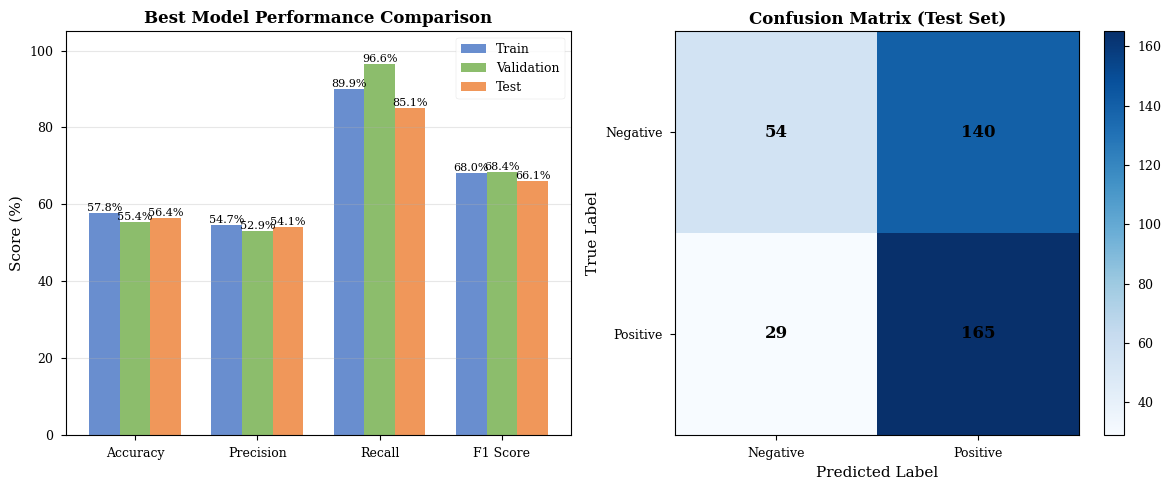

In [24]:
# ============= Create a second figure: Final Performance Comparison =============
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Bar plot comparing final metrics
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
train_final = [best_accs[0]['accuracy']*100, best_accs[0]['precision']*100, 
               best_accs[0]['recall']*100, best_accs[0]['f1']*100]
val_final = [best_accs[1]['accuracy']*100, best_accs[1]['precision']*100, 
             best_accs[1]['recall']*100, best_accs[1]['f1']*100]
test_final = [best_accs[2]['accuracy']*100, best_accs[2]['precision']*100, 
              best_accs[2]['recall']*100, best_accs[2]['f1']*100]

x = np.arange(len(metrics_names))
width = 0.25

bars1 = ax1.bar(x - width, train_final, width, label='Train', color='#4472C4', alpha=0.8)
bars2 = ax1.bar(x, val_final, width, label='Validation', color='#70AD47', alpha=0.8)
bars3 = ax1.bar(x + width, test_final, width, label='Test', color='#ED7D31', alpha=0.8)

ax1.set_ylabel('Score (%)')
ax1.set_title('Best Model Performance Comparison', fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics_names)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim([0, 105])

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=8)

# Confusion matrix visualization for test set
confusion_data = [
    [best_accs[2]['true_neg'], best_accs[2]['false_pos']],
    [best_accs[2]['false_neg'], best_accs[2]['true_pos']]
]

im = ax2.imshow(confusion_data, cmap='Blues', aspect='auto')
ax2.set_xticks([0, 1])
ax2.set_yticks([0, 1])
ax2.set_xticklabels(['Negative', 'Positive'])
ax2.set_yticklabels(['Negative', 'Positive'])
ax2.set_xlabel('Predicted Label')
ax2.set_ylabel('True Label')
ax2.set_title('Confusion Matrix (Test Set)', fontweight='bold')

# Add text annotations
for i in range(2):
    for j in range(2):
        text = ax2.text(j, i, confusion_data[i][j],
                       ha="center", va="center", color="black", fontsize=12, fontweight='bold')

plt.colorbar(im, ax=ax2)

plt.tight_layout()
plt.savefig('final_performance_comparison.pdf', bbox_inches='tight', dpi=300)
print("Saved: final_performance_comparison.pdf")
plt.show()

## ROC-AUC Graph

Saved: roc_auc_comparison.pdf


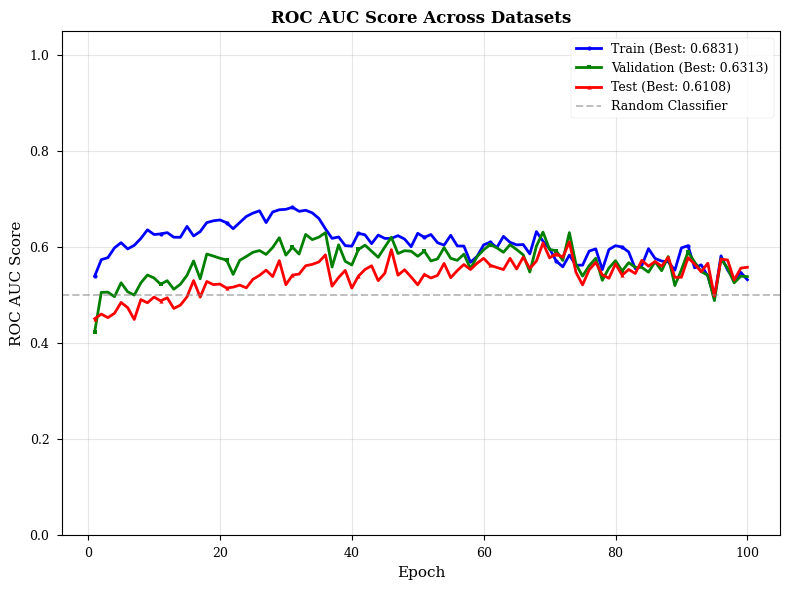

In [25]:
# ============= Create a third figure: ROC AUC comparison =============
fig3, ax = plt.subplots(figsize=(8, 6))

train_auc = [s['roc_auc'] for s in scores_train]
val_auc = [s['roc_auc'] for s in scores_val]
test_auc = [s['roc_auc'] for s in scores_test]

ax.plot(epochs, train_auc, 'b-', linewidth=2, label=f"Train (Best: {max(train_auc):.4f})", 
        marker='o', markersize=3, markevery=10)
ax.plot(epochs, val_auc, 'g-', linewidth=2, label=f"Validation (Best: {max(val_auc):.4f})", 
        marker='s', markersize=3, markevery=10)
ax.plot(epochs, test_auc, 'r-', linewidth=2, label=f"Test (Best: {max(test_auc):.4f})", 
        marker='^', markersize=3, markevery=10)

ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Random Classifier')
ax.set_xlabel('Epoch')
ax.set_ylabel('ROC AUC Score')
ax.set_title('ROC AUC Score Across Datasets', fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(loc='best')
ax.set_ylim([0, 1.05])

plt.tight_layout()
plt.savefig('roc_auc_comparison.pdf', bbox_inches='tight', dpi=300)
print("Saved: roc_auc_comparison.pdf")
plt.show()